In [ ]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [3]:
dataframe = pd.read_csv("A_Z Handwritten Data.csv")

In [4]:
xtr, xte, ytr, yte = train_test_split(dataframe[dataframe.columns[1:785]], dataframe["0"], test_size = 0.3)
xtr = xtr.to_numpy().astype("float32")
xte = xte.to_numpy().astype("float32")
xtr.shape = (260715, 1, 28, 28)
xte.shape = (111735, 1, 28, 28)
xtr = T.from_numpy(xtr)
xte = T.from_numpy(xte)
ytr = F.one_hot(T.from_numpy(ytr.to_numpy().astype("int64"))).float()
yte = F.one_hot(T.from_numpy(yte.to_numpy().astype("int64"))).float()

In [5]:
def batching(size, length):
    rvalue = []
    for i in range(size):
        rvalue.append(np.random.randint(0, length - 1))
    return rvalue

In [16]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size = 3, padding = 1),
            nn.Conv2d(4, 16, kernel_size = 3, padding = 1),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            
            nn.Conv2d(16, 64, kernel_size = 3, padding = 1),
            nn.Conv2d(64, 256, kernel_size = 3, padding = 1),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            
            nn.Flatten(),
            nn.Linear(12544, 4096),
            nn.Linear(4096, 1024),
            nn.Linear(1024, 26)
        )
    def forward(self, x):
        return self.network(x)
model = Model()

In [16]:
ALPHA = 0.0005
EPOCHS = 50
BATCH_SIZE = 256
TEST_SIZE = 100
TEST_FREQ = 10

criterion = nn.CrossEntropyLoss()
opt = T.optim.Adam(model.parameters(), lr = ALPHA)

for i in range(EPOCHS):
    batchinds = batching(BATCH_SIZE, 260715)
    testacc = 0
    output = model(xtr[batchinds])
    loss = criterion(output, ytr[batchinds])
    loss.backward()
    opt.step()
    opt.zero_grad()
    if i % TEST_FREQ == TEST_FREQ - 1:
        with T.no_grad():
            trainloss = loss.item()
            batchinds = batching(TEST_SIZE, 111735)
            pred = model(xte[batchinds])
            results = yte[batchinds]
            for j in range(len(pred.tolist())):
                if (pred[j].tolist().index(max(pred[j].tolist())) == results[j].tolist().index(1)):
                    testacc += 1
            testacc /= TEST_SIZE / 100
            print("Epoch: {} Training Loss: {}, Testing Acc: {}%".format(i + 1, trainloss, testacc))
with T.no_grad():
    testacc = 0
    inds = batching(10000, 111735)
    pred = model(xte[inds])
    results = yte[inds]
    for j in range(len(pred.tolist())):
        if (pred[j].tolist().index(max(pred[j].tolist())) == results[j].tolist().index(1)):
            testacc += 1
    testacc /= 100
    print("Final Evaluation: {}%".format(testacc))

Epoch: 10 Training Loss: 0.4003906846046448, Testing Acc: 87.0%
Epoch: 20 Training Loss: 0.31112420558929443, Testing Acc: 89.0%
Epoch: 30 Training Loss: 0.26617905497550964, Testing Acc: 93.0%
Epoch: 40 Training Loss: 0.1875021606683731, Testing Acc: 93.0%
Epoch: 50 Training Loss: 0.20443065464496613, Testing Acc: 88.0%
Final Evaluation: 92.72%


p


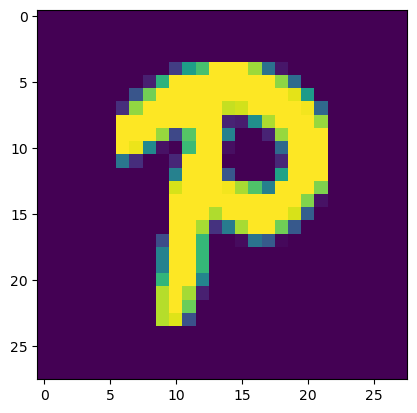

In [65]:
n = random.randint(0, 111734)
letters = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n',
          'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
plt.imshow(xte[n].squeeze())
with T.no_grad():
    print(letters[T.argmax(model(xte[n].unsqueeze(0)), dim = -1).item()])

In [34]:
T.save(model.state_dict(), 'letterclassifier.pt')

In [ ]:
import torchvision as tv
trained = Model()
trained.load_state_dict(T.load('letterclassifier.pt'))
transform = tv.transforms.Compose([
    tv.transforms.Resize((28, 28), antialias = True),
    tv.transforms.RandomInvert(),
    tv.transforms.Grayscale()
])
img = tv.io.read_image('image.png')
img = tv.transforms.functional.invert(img)
img = transform(img).float().unsqueeze(0)
plt.imshow(img.squeeze())
print(trained(img).argmax(dim = -1) + 1)